In [ ]:
# !pip install protobuf==4.25.1
# !pip install tensorflow==2.14
# !pip install numpy
# !pip install plotly
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install contractions
# !pip install nltk
# !pip install nbformat>=4.2.0
# !pip install fasttext
# !pip install keras-self-attention

# LIBRARY

In [1]:
import pandas as pd
import numpy as np
import time
import re
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Attention, Input, concatenate, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras_self_attention import SeqSelfAttention

import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import fasttext

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import contractions
from contractions import contractions_dict

from collections import Counter

dataset_name = 'data/Consumer_Complaint.csv'


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# LOAD DATASET

In [3]:
data_raw = pd.read_csv(dataset_name)
data_raw.info()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_171316\690996576.py:1: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(dataset_name)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282355 entries, 0 to 1282354
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1282355 non-null  object
 1   Product                       1282355 non-null  object
 2   Sub-product                   1047189 non-null  object
 3   Issue                         1282355 non-null  object
 4   Sub-issue                     751169 non-null   object
 5   Consumer complaint narrative  383564 non-null   object
 6   Company public response       449082 non-null   object
 7   Company                       1282355 non-null  object
 8   State                         1262955 non-null  object
 9   ZIP code                      1167057 non-null  object
 10  Tags                          175643 non-null   object
 11  Consumer consent provided?    690654 non-null   object
 12  Submitted via                 1282355 non-

## FILTER

In [4]:
Text = "Consumer complaint narrative"
Label = "Product"

data_Clean = data_raw[[Text,Label]].copy().dropna()

data_Clean.rename(columns = {Text:'Text',Label:'Label'}, inplace = True)

data_Clean.info()
data_Clean.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 383564 entries, 29904 to 912553
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    383564 non-null  object
 1   Label   383564 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


,Text,Label
29904,The Summer of XX/XX/2018 I was denied a mortga...,"Credit reporting, credit repair services, or o..."
30629,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
30735,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
30795,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
30807,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
30857,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
30977,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
31013,There are many mistakes appear in my report wi...,"Credit reporting, credit repair services, or o..."
31078,There is an account reporting on my credit rep...,"Credit reporting, credit repair services, or o..."
31458,The reason for my writing is to inform you tha...,"Credit reporting, credit repair services, or o..."


## VISUALIZATION

In [74]:
groups = data_Clean.groupby(by='Label').count()['Text']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups.values,
    marker_color='cadetblue',
    width=0.4, 
    text=groups,
    textposition='outside'
))

fig.update_layout(title=f'Số lượng văn bản có trong mỗi lớp của tập dữ liệu Consumer Complaint Database', title_x=0.5,  yaxis=dict(range=[0, 150000]))

fig.show()

In [75]:
data_Clean.replace({'Label':
             {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}
            }, inplace= True)


groups = data_Clean.groupby(by='Label').count()['Text']

fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups.values,
    marker_color='cadetblue',
    width=0.4, 
    text=groups,
    textposition='outside'
))

fig.update_layout(title=f'Số lượng văn bản có trong mỗi lớp của tập dữ liệu Consumer Complaint Database', title_x=0.5,  yaxis=dict(range=[0, 150000]))

fig.show()

In [76]:
large_groups = data_Clean.groupby(by='Label').count()['Text']
groups = large_groups[large_groups > 10000]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups.values,
    marker_color='cadetblue',
    width=0.4, 
    text=groups,
    textposition='outside'
))

fig.update_layout(title=f'Số lượng văn bản có trong mỗi lớp của tập dữ liệu Consumer Complaint Database', title_x=0.5,  yaxis=dict(range=[0, 150000]))

fig.show()

In [8]:
data_text =  data_Clean.loc[data_Clean['Label'].isin(groups.index)].reset_index(drop=True)
data_text.info()
data_text.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327140 entries, 0 to 327139
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    327140 non-null  object
 1   Label   327140 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB


,Text,Label
0,The Summer of XX/XX/2018 I was denied a mortga...,"Credit reporting, repair, or other"
1,There are many mistakes appear in my report wi...,"Credit reporting, repair, or other"
2,There are many mistakes appear in my report wi...,"Credit reporting, repair, or other"
3,There are many mistakes appear in my report wi...,"Credit reporting, repair, or other"
4,There are many mistakes appear in my report wi...,"Credit reporting, repair, or other"


# PRE-PROCESSING

In [ ]:
def pre_Processing(data):
  '''
  # Đổi văn bản thô sang văn bản gốc
  Ví dụ:
        He played football while she was playing tennis. The request was denied. He goes to school. She bakes cakes. I'm gonna go to the store
        He play football while she be play tennis . The request be deny . He go to school . She bake cake . I be go to go to the store
  '''
  def lemmatization_and_stemming(text):
    lemmatization =  ' '.join([contractions_dict.get(word, word) for word in text.split()])
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in lemmatization.split()])

  # Hàm loại bỏ stop words
  def remove_stop_words(text):
      # Lấy danh sách stop words tiếng Anh
      stop_words = set(stopwords.words('english'))
      words = text.split()
      filtered_words = [word for word in words if word not in stop_words]
      return ' '.join(filtered_words)
  
  # đưa các từ viết tắt về nguyên mẫu
  data['Text'] = data['Text'].apply(lemmatization_and_stemming)

  # đưa về chữ thường
  data['Text'] = data['Text'].str.lower()
  
  # loại bỏ ký tự đặc biệt và số
  data['Text'] = data['Text'].apply(lambda x: re.sub('[^a-z]', ' ', str(x)))

  # Xóa từ dừng
  data['Text'] = data['Text'].apply(remove_stop_words)
  
  # loại các text null
  data = data[data['Text'] != ""]

  return data[['Text', 'Label']]

data_processing = pre_Processing(data_text)

name_data_processing = "data/Consumer_Complaint_processing.csv"
# Xuất DataFrame thành file .csv
data_processing.to_csv(name_data_processing, index=False, encoding='utf-8')

data_processing.info()
data_processing.head()

In [26]:
data_sample = data_processing.copy()
data_sample["length"] = data_sample["Text"].apply(lambda x: len(x.split()))
data_sample["length"].describe()

count    354905.000000
mean         98.229721
std         108.799405
min           1.000000
25%          35.000000
50%          67.000000
75%         123.000000
max        4505.000000
Name: length, dtype: float64

# Tokenizer

In [2]:
name_data_processing = "data/Consumer_Complaint_processing.csv"
data_processing = pd.read_csv(name_data_processing).sample(n=200000, replace=False)

data_tokenizer = data_processing.copy()
# Tách từ
data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)


data_tokenizer.info()
data_tokenizer.head()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 184251 to 266814
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    200000 non-null  object
 1   Label   200000 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


,Text,Label
184251,"[try, order, free, annual, credit, report, exp...","Credit reporting, repair, or other"
35047,"[recievables, performance, management, send, b...",Debt collection
23170,"[experian, report, open, date, payment, histor...","Credit reporting, repair, or other"
41042,"[concern, discrepancy, information, company, u...","Credit reporting, repair, or other"
231414,"[well, fargo, deduct, personal, account, cover...",Credit card or prepaid card


In [ ]:
# import ast

# selected_df = pd.read_csv("data/Consumer_Complaint_tokenizer.csv",  converters={'Text': ast.literal_eval})

# number_per = 10000
# # Khởi tạo danh sách để lưu trữ văn bản đã chọn
# data_tokenizer = pd.DataFrame(columns=['Text', 'Label'])

# for Label in selected_df["Label"].unique():
#     label_indices = selected_df[selected_df['Label'] == Label].index

     
#     # Lấy mẫu ngẫu nhiên từ các chỉ mục thuộc nhãn hiện tại
#     selected_indices = np.random.choice(label_indices, size=min(number_per, len(label_indices)), replace=False)
    
#     # Thêm các dòng đã chọn vào DataFrame mới
#     data_tokenizer = pd.concat([data_tokenizer, selected_df.loc[selected_indices]])

# print(data_tokenizer.shape)

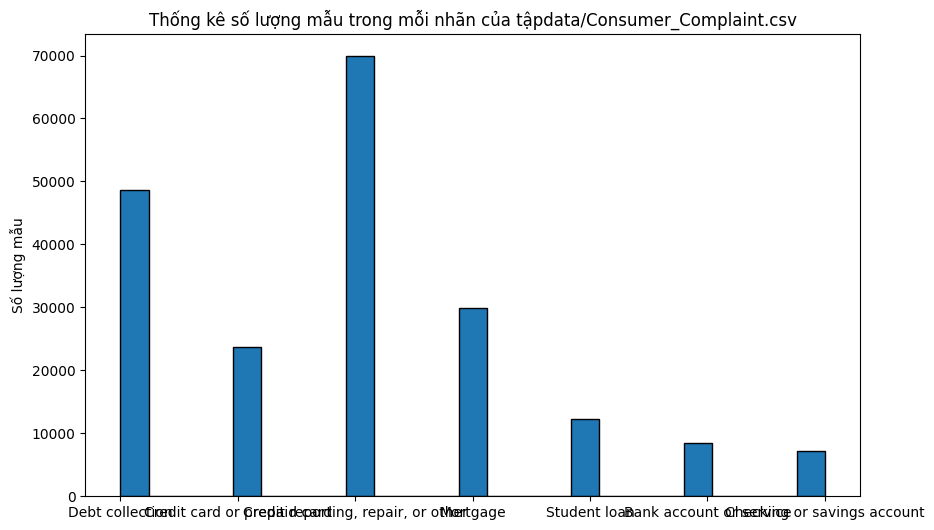

In [81]:

# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(data_tokenizer["Label"].values, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Thống kê số lượng mẫu trong mỗi nhãn của tập' + dataset_name)
plt.ylabel('Số lượng mẫu')
plt.show()

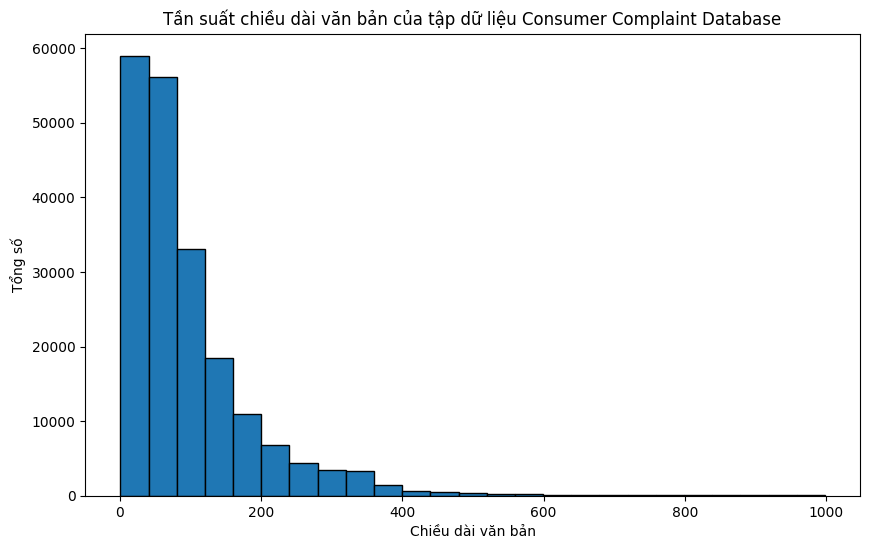

In [82]:
lenght = []
for i in data_tokenizer["Text"].values:
    if len(i) < 1000:
        lenght.append(len(i))

# Đặt kích thước của hình vẽ
plt.figure(figsize=(10, 6))
# Vẽ biểu đồ tần suất
plt.hist(lenght, bins=25, edgecolor='black')  # bins là số lượng cột trong histogram
plt.title('Tần suất chiều dài văn bản của tập dữ liệu Consumer Complaint Database')
plt.xlabel('Chiều dài văn bản')
plt.ylabel('Tổng số')
plt.show()

# Labels

In [4]:
# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Label"].values)

def encode_label(label):
    return label_encoder.transform(label)

def decode_label(label):
    return label_encoder.inverse_transform(label)


In [12]:
# 80 90 100
max_length = 90

def tokenization(data):
    Text_col = data["Text"]
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(Text_col)
    words_to_index = tokenizer.word_index
    vocab_size = len(words_to_index) + 1
    
    # chuyển đổi dữ liệu văn bản thành các chuỗi số 
    tokenizer_seq = tokenizer.texts_to_sequences(Text_col)

    # Đảm bảo mỗi sequece có cùng độ dài 
    # 'post' có nghĩa là thêm padding vào cuối mỗi sequence
    # 'pre' có nghĩa là thêm padding vào đầu mỗi sequence
    tokenizer_pad = pad_sequences(tokenizer_seq, padding='post', maxlen=max_length)

    return tokenizer_pad, vocab_size, words_to_index

data_tokenizer_pad, vocab_size, words_to_index = tokenization(data_tokenizer)

# Word Embedding - FastText

In [15]:
path_txt = f'data/fasttext/text_complaint_{data_processing["Text"].shape[0]}.txt'

with open(path_txt, 'w') as file:
    # Write content to the 
    for i in data_processing["Text"]:
        file.write(i+"\n")

# Training the fastText classifier
model = fasttext.train_unsupervised('data/fasttext/text_complaint.txt', maxn=0, dim=100)
model.save_model('model/fasttext/complaint_fasttext_100d.bin')

In [14]:
ft = fasttext.load_model('model/word_embedding/complaint_fasttext_100d.bin')
embed_vector_size = ft.get_word_vector("you").shape[0]

embed_vector_matrix = np.zeros((vocab_size, embed_vector_size))

for word, i in words_to_index.items():
    embedding_vector = ft.get_word_vector(word)
    if any(embedding_vector):
        embed_vector_matrix[i] = embedding_vector
    else:
        embed_vector_matrix[i] = np.random.uniform(low=-1, high=1, size= embed_vector_size)

print(f"Max length | input_length      = {max_length}")
print(f"input_dim  | vocab_size        = {vocab_size}")
print(f"output_dim | embed_vector_size = {embed_vector_size}")
print(f"weights = {embed_vector_matrix.shape}")

embedding = Embedding(input_dim=vocab_size, output_dim=embed_vector_size, 
                      input_length=max_length, weights=[embed_vector_matrix], trainable=False)

Max length | input_length      = 90
input_dim  | vocab_size        = 71982
output_dim | embed_vector_size = 100
weights = (71982, 100)


# Model

In [130]:
classes = data_tokenizer['Label'].nunique()
print(f"Number labels = {classes}")

def create_model(hidden_layers):
    model = Sequential()
    model.add(embedding)
    model.add(LSTM(hidden_layers, return_sequences=True))
    model.add(LSTM(hidden_layers, return_sequences=True))
    model.add(LSTM(hidden_layers, return_sequences=True))
    model.add(SeqSelfAttention())
    model.add(Flatten())
    model.add(Dense(classes, activation="softmax"))

    # Model compiling
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Number labels = 7


# Train_Test_Validation split 

In [13]:
data_tokenizer["encode_Label"] = encode_label(data_tokenizer["Label"].values)

# Chia dataset thành tập training thành train_val và test
X_train_val, X_test, y_train_val, y_test = train_test_split(data_tokenizer_pad, data_tokenizer["encode_Label"].values, test_size=0.2, random_state=40)

# Chia train_val thành train và validation
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=40)

print("Size Train: ",X_train.shape, y_train.shape)
print("Size Test: ",X_test.shape, y_test.shape)
print("Size Validation: ",X_val.shape, y_val.shape)

Size Train:  (120000, 90) (120000,)
Size Test:  (40000, 90) (40000,)
Size Validation:  (40000, 90) (40000,)


# Run

In [132]:
hidden_layers = 100
model = create_model(hidden_layers)
batchSize = round(X_train.shape[0] * 0.045)
epoch = 20
print(batchSize)
model.summary()

5400
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          7239200   
                                                                 
 lstm_3 (LSTM)               (None, 100, 100)          80400     
                                                                 


c:\Users\Administrator\Desktop\text_classification\.venv\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.



 lstm_4 (LSTM)               (None, 100, 100)          80400     
                                                                 
 lstm_5 (LSTM)               (None, 100, 100)          80400     
                                                                 
 seq_self_attention_1 (SeqS  (None, 100, 100)          6465      
 elfAttention)                                                   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 7)                 70007     
                                                                 
Total params: 7556872 (28.83 MB)
Trainable params: 317672 (1.21 MB)
Non-trainable params: 7239200 (27.62 MB)
_________________________________________________________________


In [102]:
# Ghi lại thời điểm bắt đầu
start_time = time.time()

lstm_model_history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epoch, validation_data=(X_val, y_val))

# Tính thời gian đã trôi qua
training_time = round(time.time() - start_time, 2)

Epoch 1/20
 2/23 [=>............................] - ETA: 1:31:00 - loss: 1.9237 - accuracy: 0.2138

In [48]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

263/263 [==============================] - 88s 335ms/step - loss: 0.8281 - accuracy: 0.7260
Test Score: 0.828088641166687
Test Accuracy: 0.7259523868560791


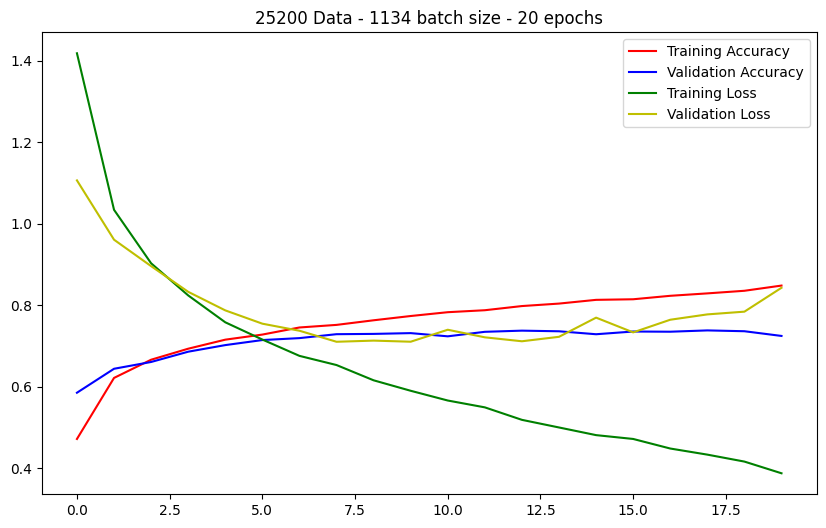

In [49]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,6))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    
    plt.title(f'{X_train.shape[0]} Data - {batchSize} batch size - {epoch} epochs')
    plt.legend(loc=0)
    plt.show()


plot_graph(lstm_model_history)
    

In [50]:
path = f"model/Complaint/complaint_{max_length}_{X_train.shape[0]}_{batchSize}_{epoch}_{training_time}.h5"
model.save(path)

c:\Users\Administrator\Desktop\text_classification\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
path = "model/Complaint/complaint_100_120000_5400_20_41923.49.h5"
# Register the custom object
with tf.keras.utils.custom_object_scope({'SeqSelfAttention': SeqSelfAttention}):
    model = load_model(path)

c:\Users\Administrator\Desktop\text_classification\.venv\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [116]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          7224700   
                                                                 
 lstm_6 (LSTM)               (None, 100, 100)          80400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 100)          80400     
                                                                 
 lstm_8 (LSTM)               (None, 100, 100)          80400     
                                                                 
 seq_self_attention_2 (SeqS  (None, 100, 100)          6465      
 elfAttention)                                                   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                      

In [8]:

start = None
end = None

# Phân loại 
y_pred = model.predict(X_test[start:end])
# Mã hóa label
y_pred_original = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_original = label_encoder.inverse_transform(y_test[start:end])

# In ra kết quả phân loại
print(f"Kết quả thực tế: {y_test_original}")
print(f"Kết quả mô hình phân loại: {y_pred_original} - {y_pred_original == y_test_original}")



1250/1250 [==============================] - 232s 184ms/step
Kết quả thực tế: ['Debt collection' 'Credit card or prepaid card' 'Mortgage' ...
 'Credit reporting, repair, or other' 'Student loan' 'Debt collection']
Kết quả mô hình phân loại: ['Debt collection' 'Credit card or prepaid card' 'Mortgage' ...
 'Credit card or prepaid card' 'Mortgage'
 'Credit reporting, repair, or other'] - [ True  True  True ... False False False]


In [9]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

1250/1250 [==============================] - 256s 204ms/step - loss: 1.3632 - accuracy: 0.5421
Test loss: 1.3632221221923828
Test Accuracy: 0.5421000123023987


In [10]:
# Tìm tất cả các nhãn duy nhất
labels = np.unique(np.concatenate((y_test_original, y_pred_original)))

# Tạo ma trận confusion
confusion = confusion_matrix(y_test_original, y_pred_original, labels=labels)

print("Ma trận confusion:")
print(confusion)

Ma trận confusion:
[[ 130   75  441  240  444  242   50]
 [  56   96  401  214  421  213   41]
 [  40   25 2238  800 1174  359   86]
 [  22   32  751 9553 2623  668  137]
 [  38   37  523 2139 6225  666  214]
 [  72   58  451  945 1214 3129  208]
 [  33   14  202  552  562  833  313]]


In [11]:
# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test_original, y_pred_original, average=None)
recall_per_class = recall_score(y_test_original, y_pred_original, average=None)
f1_per_class = f1_score(y_test_original, y_pred_original, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = round(np.mean(precision_per_class)*100,1)
macro_recall = round(np.mean(recall_per_class)*100,1)
macro_f1 = round(np.mean(f1_per_class)*100,1)

# Create a DataFrame for the table
metrics_table_per_class = pd.DataFrame({
    'Class': np.unique(y_test_original),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Print the table per class
print("Metrics Table per Class:")
print(metrics_table_per_class)

# Print macro-average metrics
print("\nMacro-Average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")

Metrics Table per Class:
                                Class  Precision    Recall  F1 Score
0             Bank account or service   0.332481  0.080148  0.129160
1         Checking or savings account   0.284866  0.066574  0.107926
2         Credit card or prepaid card   0.446974  0.473952  0.460068
3  Credit reporting, repair, or other   0.661428  0.692949  0.676822
4                     Debt collection   0.491590  0.632493  0.553210
5                            Mortgage   0.512111  0.514892  0.513498
6                        Student loan   0.298379  0.124751  0.175942

Macro-Average Metrics:
Macro Precision: 43.3
Macro Recall: 36.9
Macro F1 Score: 37.4
